In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn
from sklearn.metrics import f1_score, confusion_matrix

# импортируем трансформеры
import transformers
from transformers import AutoTokenizer, AutoModel
import warnings

warnings.filterwarnings("ignore")
from src.fit_model import (
    #     fit_model,
    #     fit_with_mlflow,
    plot_history,
    #     binary_metrics,
    #     multiclass_metrics,
)

In [2]:
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    MulticlassPrecision,
    MulticlassAccuracy,
    MulticlassConfusionMatrix,
    MulticlassRecall,
    MulticlassF1Score,
)

In [3]:
import multiprocessing as mp
from dataclasses import dataclass
from typing import Union
from tqdm.auto import tqdm
import mlflow
from time import time
import os
from tqdm.auto import tqdm
import mlflow
import re

sklearn.set_config(transform_output="pandas")

In [4]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# GENERATOR = (
#     torch.Generator(device=DEVICE) if torch.cuda.is_available() else torch.Generator()
# )
GENERATOR = torch.Generator()

use_mlflow = True
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 200
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

CURR_DIR = os.curdir

In [5]:
%load_ext autoreload
%autoreload 2

# Задание 1

## Загрузка и подготовка датасетов

In [6]:
df_train = pd.read_csv(os.path.join(CURR_DIR, "tg_channels", "train_channels.csv"))
df_valid = pd.read_csv(os.path.join(CURR_DIR, "tg_channels", "val_channels.csv"))
df_test = pd.read_csv(os.path.join(CURR_DIR, "tg_channels", "test_channels.csv"))
df = pd.concat((df_train.copy(), df_valid.copy()), axis=0)
print(df_train.shape[0], df_valid.shape[0], df.shape[0])
df.reset_index(inplace=True)
df = df.drop("index", axis=1)
df.tail()

24804 6201 31005


,date,content,label,initial_text
31000,2023-03-30 11:15:43+00:00,"Посетить спектакль, и при этом все равно что п...",искусство,"Посетить спектакль, и при этом все равно что п..."
31001,2023-08-22 09:16:00+00:00,⚡️ Производители итальянского сыра добавляют в...,технологии,⚡️ Производители итальянского сыра добавляют в...
31002,2023-05-03 17:17:00+00:00,​Приманка хакера. Как создать Honeypot использ...,технологии,​Приманка хакера. Как создать Honeypot использ...
31003,2023-06-20 13:13:08+00:00,"Интересно, а если перед рекламой дописывать ЭТ...",маркетинг,"Интересно, а если перед рекламой дописывать ЭТ..."
31004,2023-05-08 09:39:00+00:00,"🔴🔤🔤🔤🔤🔤🔤 🔤🔤🔤🔤🔴🎙Друзья, сообщаем, что в четверг,...",образование_познавательное,"🔴🔤🔤🔤🔤🔤🔤 🔤🔤🔤🔤🔴🎙Друзья, сообщаем, что в четверг,..."


In [7]:
df_train.head()

,date,content,label,initial_text
0,2023-07-05 15:16:45+00:00,Две ссылкиРас: https://t.me/PlushevChannel/224...,технологии,Две ссылкиРас: https://t.me/PlushevChannel/224...
1,2023-07-11 13:13:02+00:00,"@firstartclub | #обзор«Отец», Константин Аполл...",искусство,"@firstartclub | #обзор«Отец», Константин Аполл..."
2,2022-12-17 07:55:28+00:00,"pov: когда объясняют новую тему урока, а ты ещ...",образование_познавательное,"pov: когда объясняют новую тему урока, а ты ещ..."
3,2023-05-25 10:37:54+00:00,⚡️Грузинская авиакомпания Georgian Airways зап...,маркетинг,⚡️Грузинская авиакомпания Georgian Airways зап...
4,2020-08-03 10:01:15+00:00,"Интересуешься историей и людьми, которые ее со...",образование_познавательное,"Интересуешься историей и людьми, которые ее со..."


In [8]:
df_valid.head()

,date,content,label,initial_text
0,2021-09-03 15:39:58+00:00,ВКонтакте и Одноклассниках будут помечать пост...,технологии,ВКонтакте и Одноклассниках будут помечать пост...
1,2023-08-03 08:01:13+00:00,Гид покупателя: разбираемся в тонкостях умных ...,технологии,Гид покупателя: разбираемся в тонкостях умных ...
2,2023-04-06 10:53:04+00:00,"Как понять, что ребёнок курит вейп? 💨Рассказыв...",здоровье_медицина,"Как понять, что ребёнок курит вейп? 💨Рассказыв..."
3,2022-09-13 12:28:47+00:00,В Третьяковке выходят из онлайна в реальность....,искусство,В Третьяковке выходят из онлайна в реальность....
4,2022-04-28 08:20:38+00:00,"Я, честно говоря, как старый фанат ЗВ обалдел,...",искусство,"Я, честно говоря, как старый фанат ЗВ обалдел,..."


In [9]:
df_test.head()

,date,content,label,initial_text
0,2023-05-24 06:42:11+00:00,Мастерство заголовков от РБК Прочитал заголово...,маркетинг,Мастерство заголовков от РБК Прочитал заголово...
1,2023-09-18 12:30:05+00:00,​Революция в оптимизаторах: DeepMind используе...,технологии,​Революция в оптимизаторах: DeepMind используе...
2,2022-10-10 06:25:33+00:00,Телеведущий Эта профессия считается довольно...,образование_познавательное,Телеведущий Эта профессия считается довольно...
3,2021-10-01 10:37:00+00:00,"​Когда-нибудь задумывались, что из-за поврежде...",здоровье_медицина,"​Когда-нибудь задумывались, что из-за поврежде..."
4,2023-02-12 13:04:31+00:00,Эта собака провела в отделении интенсивной тер...,здоровье_медицина,Эта собака провела в отделении интенсивной тер...


## Загрузка модели

**Модель rubert-tiny2** https://huggingface.co/cointegrated/rubert-tiny2

In [10]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [11]:
text = df_train.loc[4, "content"]
text

'Интересуешься историей и людьми, которые ее создали, но не любишь читать тонны скучной информации?\xa0Тогда советую перейти на канал Нескучные личности\xa0\xa0\xa0Здесь только интересная информация и факты, которые не надоедают.Подписывайся и удиви всех своими знаниями.'

In [12]:
encoded_input = tokenizer(text)
encoded_input

{'input_ids': [2, 32305, 644, 35256, 36666, 320, 21667, 16, 2938, 22234, 33541, 16, 1363, 769, 57757, 32421, 48177, 47876, 775, 9280, 35, 18579, 53143, 33588, 548, 13233, 51819, 1305, 8212, 18928, 15203, 2768, 44926, 17201, 320, 35669, 16, 2938, 769, 39132, 27760, 18, 59022, 61133, 938, 320, 36338, 613, 4366, 16204, 47579, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer.decode(32305)

'Интерес'

In [14]:
encoded_posts = (
    df["content"]
    .apply(lambda x: tokenizer(x, max_length=64, truncation=True, padding="max_length"))
    .values
)
encoded_posts

array([{'input_ids': [2, 23706, 35999, 4845, 4992, 30, 2986, 30, 19, 19, 87, 18, 1127, 19, 5414, 1607, 846, 1097, 1694, 4669, 19, 6451, 1140, 1290, 8759, 2112, 30, 2986, 30, 19, 19, 859, 18, 85, 21332, 18, 2643, 19, 5646, 67, 537, 67, 2120, 19, 1078, 19, 1107, 19, 42271, 19, 1375, 539, 1290, 24339, 15582, 1433, 539, 1383, 1433, 29506, 5864, 1320, 587, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
       {'input_ids': [2, 36, 804, 3623, 11205, 1, 7, 33238, 105, 18876, 117, 16, 10849, 79003, 3190, 46822, 68765, 12, 2139, 13, 39251, 5382, 20113, 17, 105, 297, 42435, 36789, 5189, 66687, 1229, 32770, 1373, 117, 18,

In [15]:
print(f"Source text: {df['content'][10]}")
print(f"Encoded text: {encoded_posts[10]}")
print(f"Length: {len(encoded_posts)}")

Source text: Шоу «Стыдно знать» от комика Андрея Бебуришвили,  «Соври, если сможешь» с Лизой Анохиной и творческая лаборатория «Гараж» со Slava Marlow — Дзен решил привлечь как можно больше зумеров.  Очевидно, команда платформы не отступает от заложенного вектора и стремится омолодить пользовательскую аудиторию. Всего в Дзене выйдут 8 разноформатных проектов с блогерами и звездами.
Encoded text: {'input_ids': [2, 44428, 105, 51870, 700, 10412, 30973, 117, 733, 35617, 603, 26061, 50688, 19110, 18231, 15140, 16, 105, 33059, 1690, 16, 7081, 55454, 117, 329, 70861, 1373, 23181, 68291, 1373, 320, 58783, 39189, 105, 60029, 1845, 117, 1154, 55, 8056, 539, 3792, 8803, 1, 284, 18759, 17303, 33516, 1150, 5081, 8281, 319, 24460, 3801, 18, 38788, 16, 7402, 34100, 769, 31290, 7955, 733, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

In [16]:
class BertInputs(torch.utils.data.Dataset):
    def __init__(self, encoded_text):
        super().__init__()
        self.inputs = encoded_text

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        # print(self.inputs[idx])
        return (
            torch.Tensor(self.inputs[idx]["input_ids"]).long(),
            torch.Tensor(self.inputs[idx]["attention_mask"]).long(),
        )


dataset = BertInputs(encoded_text=encoded_posts)

In [17]:
loader = DataLoader(
    dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)
batch = next(iter(loader))
batch

[tensor([[    2, 23706, 35999,  ...,  1320,   587,     3],
         [    2,    36,   804,  ...,   778, 40191,     3],
         [    2,   867,   846,  ...,     0,     0,     0],
         ...,
         [    2,     6, 56286,  ...,     0,     0,     0],
         [    2,  1861,     7,  ...,     0,     0,     0],
         [    2, 58479,  2262,  ...,   329,  9470,     3]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]])]

## Из выхода модели делаем features (на самом деле это embeddings)

In [18]:
%%time
features = []
for inputs, masks in loader:
    with torch.inference_mode():
        model_out = model(inputs, attention_mask=masks)
        vectors = model_out.last_hidden_state[:, 0, :]
    features.extend(vectors.cpu().numpy())
len(features)

CPU times: user 3min 47s, sys: 2 s, total: 3min 49s
Wall time: 29.4 s


31005

* Теперь **features** - список векторов трансформированных моделью

In [19]:
type(features)

list

In [20]:
len(features[0])

312

In [21]:
model_out.last_hidden_state.shape

torch.Size([29, 64, 312])

## Закодируем label

In [22]:
encoder = ColumnTransformer(
    [("ordinal_enc", OrdinalEncoder(), ["label"])],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
df_encoded = encoder.fit_transform(df.copy())
df_encoded
labels = df_encoded["label"].copy().astype(int)
labels

0        4
1        1
2        3
3        2
4        3
        ..
31000    1
31001    4
31002    4
31003    2
31004    3
Name: label, Length: 31005, dtype: int64

In [25]:
df.head()

,date,content,label,initial_text
0,2023-07-05 15:16:45+00:00,Две ссылкиРас: https://t.me/PlushevChannel/224...,технологии,Две ссылкиРас: https://t.me/PlushevChannel/224...
1,2023-07-11 13:13:02+00:00,"@firstartclub | #обзор«Отец», Константин Аполл...",искусство,"@firstartclub | #обзор«Отец», Константин Аполл..."
2,2022-12-17 07:55:28+00:00,"pov: когда объясняют новую тему урока, а ты ещ...",образование_познавательное,"pov: когда объясняют новую тему урока, а ты ещ..."
3,2023-05-25 10:37:54+00:00,⚡️Грузинская авиакомпания Georgian Airways зап...,маркетинг,⚡️Грузинская авиакомпания Georgian Airways зап...
4,2020-08-03 10:01:15+00:00,"Интересуешься историей и людьми, которые ее со...",образование_познавательное,"Интересуешься историей и людьми, которые ее со..."


In [24]:
df_encoded.head(5)

,label,date,content,initial_text
0,4.0,2023-07-05 15:16:45+00:00,Две ссылкиРас: https://t.me/PlushevChannel/224...,Две ссылкиРас: https://t.me/PlushevChannel/224...
1,1.0,2023-07-11 13:13:02+00:00,"@firstartclub | #обзор«Отец», Константин Аполл...","@firstartclub | #обзор«Отец», Константин Аполл..."
2,3.0,2022-12-17 07:55:28+00:00,"pov: когда объясняют новую тему урока, а ты ещ...","pov: когда объясняют новую тему урока, а ты ещ..."
3,2.0,2023-05-25 10:37:54+00:00,⚡️Грузинская авиакомпания Georgian Airways зап...,⚡️Грузинская авиакомпания Georgian Airways зап...
4,3.0,2020-08-03 10:01:15+00:00,"Интересуешься историей и людьми, которые ее со...","Интересуешься историей и людьми, которые ее со..."


In [ ]:
# import json

# label_decoding = {
#     1: "искусство",
#     2: "маркетинг",
#     3: "образование_познавательное",
#     4: "технологии",
# }

# with open("label_decoding_rubert.json", "w", encoding="utf-8") as f:
#     json.dump(label_decoding, f, ensure_ascii=False, indent=4)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(features, labels)

In [24]:
print(f"Features shape: {len(X_train)}, Target shape: {len(y_train)}")

Features shape: 23253, Target shape: 23253


In [25]:
df["label"].value_counts() / len(features) * 100

label
технологии                    29.888728
маркетинг                     20.841800
здоровье_медицина             19.790356
образование_познавательное    16.303822
искусство                     13.175294
Name: count, dtype: float64

## Вектора после rubert отправляем в классификатор (Logistic Regression и Catboost для сравнения)

In [26]:
%%time
clf = LogisticRegression()
clf.fit(X_train, y_train)

CPU times: user 14.9 s, sys: 15.2 s, total: 30.1 s
Wall time: 2.14 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [27]:
clf.score(X_val, y_val)

0.7901186790505675

In [28]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier()
cat.fit(X_train, y_train)

Learning rate set to 0.0929
0:	learn: 1.5352671	total: 148ms	remaining: 2m 28s
1:	learn: 1.4803192	total: 263ms	remaining: 2m 11s
2:	learn: 1.4315757	total: 372ms	remaining: 2m 3s
3:	learn: 1.3931057	total: 487ms	remaining: 2m 1s
4:	learn: 1.3547762	total: 593ms	remaining: 1m 58s
5:	learn: 1.3176865	total: 702ms	remaining: 1m 56s
6:	learn: 1.2870054	total: 804ms	remaining: 1m 53s
7:	learn: 1.2600151	total: 920ms	remaining: 1m 54s
8:	learn: 1.2330919	total: 1.04s	remaining: 1m 55s
9:	learn: 1.2079176	total: 1.16s	remaining: 1m 54s
10:	learn: 1.1845294	total: 1.27s	remaining: 1m 53s
11:	learn: 1.1638548	total: 1.38s	remaining: 1m 53s
12:	learn: 1.1456524	total: 1.49s	remaining: 1m 53s
13:	learn: 1.1269738	total: 1.61s	remaining: 1m 53s
14:	learn: 1.1105198	total: 1.73s	remaining: 1m 53s
15:	learn: 1.0950270	total: 1.85s	remaining: 1m 53s
16:	learn: 1.0793263	total: 1.97s	remaining: 1m 53s
17:	learn: 1.0643540	total: 2.08s	remaining: 1m 53s
18:	learn: 1.0516971	total: 2.19s	remaining: 1m 

In [29]:
cat.score(X_val, y_val)

0.7875386996904025

In [167]:
len(X_val)

7752

## Строим метрики

Text(1877.984848484848, 0.5, 'True')

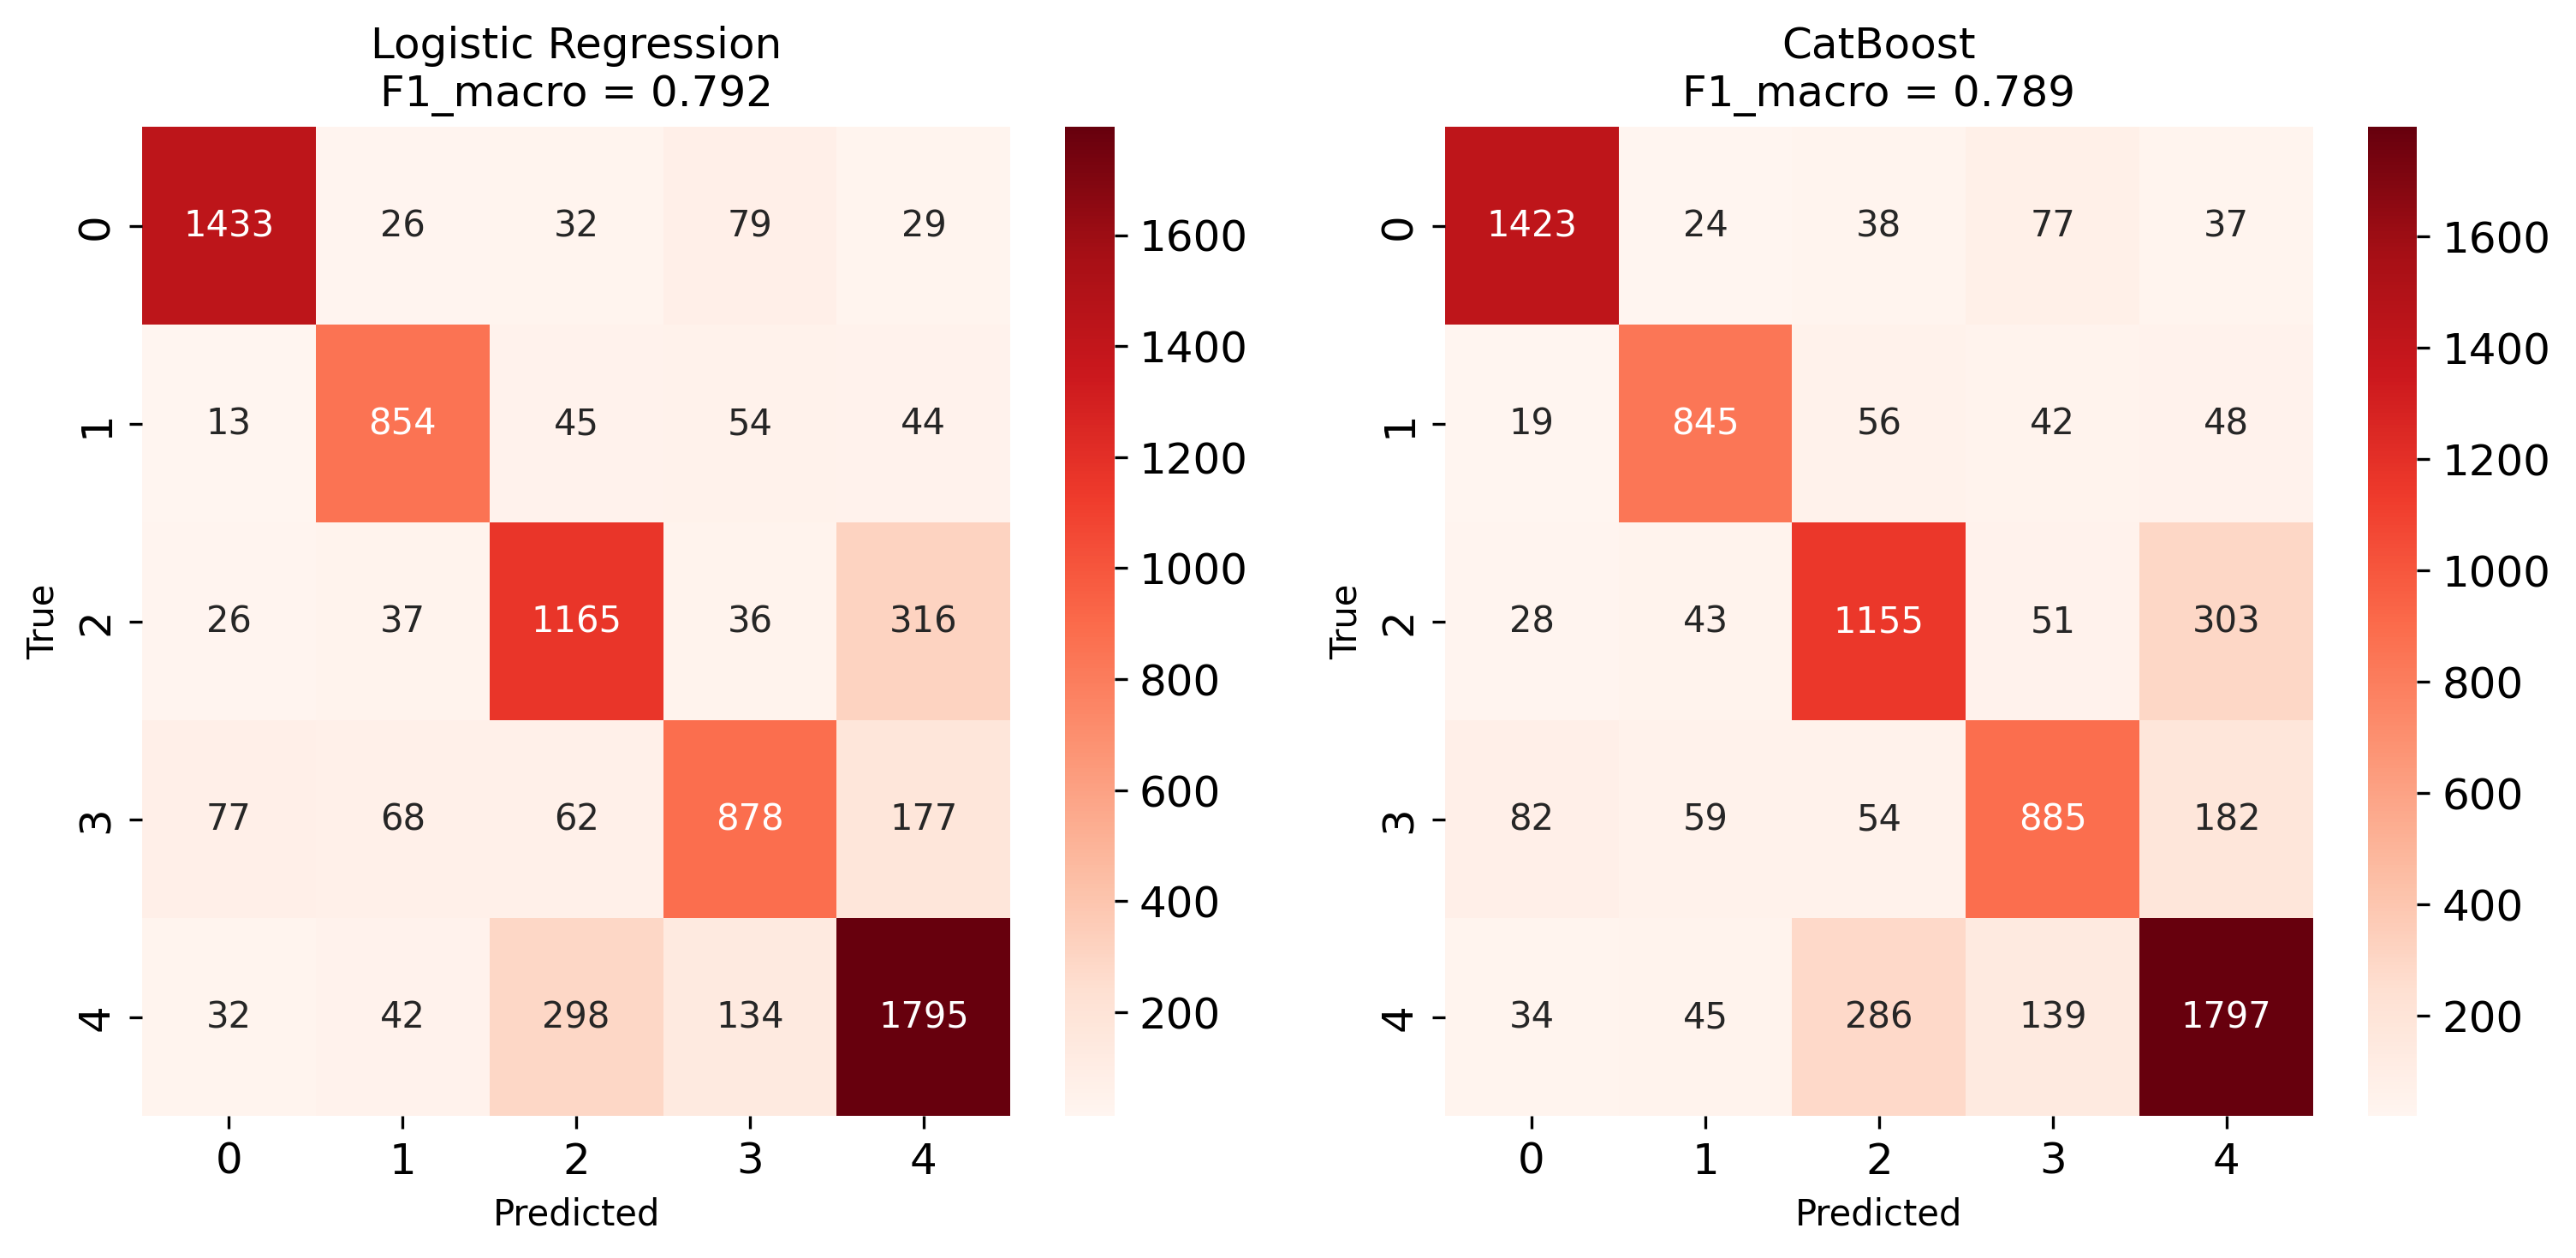

In [30]:
import seaborn as sns

y_pred_log = clf.predict(X_val)
y_pred_cat = cat.predict(X_val)

f1_log = f1_score(y_pred=y_pred_log, y_true=y_val, average="macro")
f1_cat = f1_score(y_pred=y_pred_cat, y_true=y_val, average="macro")

conf_log = confusion_matrix(y_pred=y_pred_log, y_true=y_val)
conf_cat = confusion_matrix(y_pred=y_pred_cat, y_true=y_val)

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(12, 5))
sns.heatmap(conf_log, annot=True, fmt="d", cmap="Reds", ax=ax[0])
ax[0].set_title(f"Logistic Regression\nF1_macro = {f1_log:.3f}")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(conf_cat, annot=True, fmt="d", cmap="Reds", ax=ax[1])
ax[1].set_title(f"CatBoost\nF1_macro = {f1_cat:.3f}")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

In [31]:
# fig.savefig(os.path.join(CURR_DIR, "results", "conf_matrixes.png"), bbox_inches="tight")

# Задание 2

## Подготовка модели

### Опять грузим модель (rubert-tiny2)

In [ ]:
# tokenizer_2 = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# model_2 = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model_2.cuda()  # uncomment it if you have a GPU


# # Функция прогоняет текст через руберта и возвращает embeddings
# def embed_bert_cls(text, model, tokenizer):
#     t = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
#     with torch.no_grad():
#         model_output = model(**{k: v.to(model.device) for k, v in t.items()})
#     embeddings = model_output.last_hidden_state[:, 0, :]
#     embeddings = torch.nn.functional.normalize(embeddings)
#     return embeddings[0].cpu().numpy()


# print(embed_bert_cls("привет мир", model_2, tokenizer_2).shape)

(312,)


In [108]:
tokenizer_2 = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
encoded_input = (
    df["content"]
    .apply(
        lambda x: tokenizer_2(x, max_length=64, truncation=True, padding="max_length")
    )
    .values
)
encoded_input

array([{'input_ids': [2, 23706, 35999, 4845, 4992, 30, 2986, 30, 19, 19, 87, 18, 1127, 19, 5414, 1607, 846, 1097, 1694, 4669, 19, 6451, 1140, 1290, 8759, 2112, 30, 2986, 30, 19, 19, 859, 18, 85, 21332, 18, 2643, 19, 5646, 67, 537, 67, 2120, 19, 1078, 19, 1107, 19, 42271, 19, 1375, 539, 1290, 24339, 15582, 1433, 539, 1383, 1433, 29506, 5864, 1320, 587, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
       {'input_ids': [2, 36, 804, 3623, 11205, 1, 7, 33238, 105, 18876, 117, 16, 10849, 79003, 3190, 46822, 68765, 12, 2139, 13, 39251, 5382, 20113, 17, 105, 297, 42435, 36789, 5189, 66687, 1229, 32770, 1373, 117, 18,

### Создаем свой класс на основе предобученного руберта

#### Сначала переделаем датасет

In [ ]:
class TinyBertCLSInputs(torch.utils.data.Dataset):
    def __init__(self, encoded_text, y_true):
        super().__init__()
        self.inputs = encoded_text
        self.labels = y_true

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        # print(self.inputs[idx])
        return (
            torch.tensor(self.inputs[idx]["input_ids"]).long(),
            torch.tensor(self.inputs[idx]["attention_mask"]).long(),
            torch.tensor(self.labels[idx]).long(),  # добавили для классификации
        )


dataset_2 = TinyBertCLSInputs(
    encoded_text=encoded_input, y_true=labels
)  # берем предобработанное из предыдущего задания

#### Теперь загрузчик

In [110]:
BATCH_SIZE = 128

In [111]:
# Разделяем датасеты
from torch.utils.data import Subset

train_idx, valid_idx = train_test_split(range(len(labels)), test_size=0.25)
train_ds = Subset(dataset_2, train_idx)
valid_ds = Subset(dataset_2, valid_idx)

train_loader_2 = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)
valid_loader_2 = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

#### Создаем класс модели

In [112]:
class MyPersonalTinyBert(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # и снова грузим
        self.bert = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        # заморозим параметры
        for param in self.bert.parameters():
            param.requires_grad = False
        # делаем свой слой для классификации
        self.linear = nn.Sequential(
            nn.Linear(312, 256),  # начинаем с длины embedding, которые делает модель
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 64),  # это добавил для души))
            nn.ReLU(),
            nn.Linear(64, 5),  # заканчиваем кол-вом классов
        )

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        vector = bert_out.last_hidden_state[:, 0, :]
        classes = self.linear(vector)
        return classes

In [113]:
model_3 = MyPersonalTinyBert()
model_3.to(DEVICE)

MyPersonalTinyBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

#### Критерий, оптимайзер

In [114]:
criterion = nn.CrossEntropyLoss()
LR = 2e-4
optimizer = torch.optim.Adam(model_3.parameters(), lr=LR, weight_decay=3e-5)

In [115]:
def multiclass_metrics(outputs, labels, device, num_classes):
    acc = MulticlassAccuracy(num_classes=num_classes).to(device)
    prec = MulticlassPrecision(num_classes=num_classes, average="weighted").to(device)
    rec = MulticlassRecall(num_classes=num_classes, average="weighted").to(device)
    f1 = MulticlassF1Score(num_classes=num_classes, average="weighted").to(device)

    preds = outputs.squeeze().float()
    labels = labels.squeeze().float()
    return (
        acc(preds, labels).item(),
        prec(preds, labels).item(),
        rec(preds, labels).item(),
        f1(preds, labels).item(),
    )


def fit_model(
    epochs: int,
    model: nn.Module,
    model_name: str,
    optimizer: torch.optim.Optimizer,
    criterion,
    train_loader,
    valid_loader,
    device,
    metrics_func,
    use_mlflow=False,
    num_classes=2,
):

    log = dict()
    log["train_loss"] = []
    log["valid_loss"] = []
    log["train_accuracy"] = []
    log["valid_accuracy"] = []
    log["train_precision"] = []
    log["valid_precision"] = []
    log["train_recall"] = []
    log["valid_recall"] = []
    log["train_f1"] = []
    log["valid_f1"] = []

    time_start = time()

    start_epoch = len(log["train_loss"])

    ### Создаем папку для записи весов
    # -----------------------------------------------------------------
    # Создаём корневую папку weights, если её нет
    folder_path = f"weights/"
    model_folder_path = os.path.join(folder_path, f"{model_name}")

    os.makedirs(model_folder_path, exist_ok=True)

    # Список номеров run_*
    run_nums = []

    # Ищем все подпапки с именем run_число
    for item_name in os.listdir(model_folder_path):
        full_path = os.path.join(model_folder_path, item_name)
        if os.path.isdir(full_path):
            match = re.search(r"run_(\d+)", item_name)
            if match:
                run_nums.append(int(match.group(1)))

    # Определяем следующий номер
    run = max(run_nums) + 1 if run_nums else 1

    # Создаём новую папку
    new_folder = os.path.join(model_folder_path, f"run_{run}")
    os.makedirs(new_folder, exist_ok=True)
    # -----------------------------------------------------------------

    ### Цикл обучения
    # -----------------------------------------------------------------
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):

        curr_run_path = os.path.join(folder_path, model_name, f"run_{run}")

        epoch_time_start = time()

        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        ### Обучение

        batch_acc = []
        batch_prec = []
        batch_recall = []
        batch_loss = []
        batch_f1 = []

        model.train()

        # Прогресс бар

        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=True
        )

        for inputs, masks, labels in train_pbar:

            inputs = inputs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            # Функции потерь

            outputs = model(inputs, masks)

            loss = criterion(outputs, labels.long())
            batch_loss.append(loss.item())

            # Метрики
            acc, prec, rec, f1 = metrics_func(
                outputs, labels, device=device, num_classes=num_classes
            )

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_recall.append(rec)
            batch_f1.append(f1)

            loss.backward()
            optimizer.step()

        train_pbar.set_postfix(
            {
                "Loss": loss,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1-score": f1,
            }
        )

        log["train_loss"].append(np.mean(batch_loss))
        log["train_accuracy"].append(np.mean(batch_acc))
        log["train_precision"].append(np.mean(batch_prec))
        log["train_recall"].append(np.mean(batch_recall))
        log["train_f1"].append(np.mean(batch_f1))

        ### Валидация

        batch_acc = []
        batch_prec = []
        batch_recall = []
        batch_loss = []
        batch_f1 = []

        model.eval()

        valid_pbar = tqdm(
            valid_loader, desc=f"Epoch {epoch}/{epochs} [Test]", leave=True
        )
        for inputs, masks, labels in valid_pbar:

            inputs = inputs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            with torch.no_grad():
                outputs = model(inputs, masks)

            loss = criterion(outputs, labels.long())
            batch_loss.append(loss.item())

            # Метрики
            acc, prec, rec, f1 = metrics_func(
                outputs, labels, device=device, num_classes=num_classes
            )

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_recall.append(rec)
            batch_f1.append(f1)

        valid_pbar.set_postfix(
            {
                "Loss": loss,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1-score": f1,
            }
        )
        ### Метрики и логирование

        log["valid_loss"].append(np.mean(batch_loss))
        log["valid_accuracy"].append(np.mean(batch_acc))
        log["valid_precision"].append(np.mean(batch_prec))
        log["valid_recall"].append(np.mean(batch_recall))
        log["valid_f1"].append(np.mean(batch_f1))

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            for c in log.keys():
                mlflow.log_metric(c, log[c][-1], step=epoch)

        epoch_time = time() - epoch_time_start

        ### Выводим результаты эпохи
        # Train stage
        print(
            f"Train stage: "
            f"loss: {log['train_loss'][-1]:>6.3f}  "
            f"Accuracy: {log['train_accuracy'][-1]:>6.3f}  "
            f"Precision: {log['train_precision'][-1]:>6.3f}  "
            f"Recall: {log['train_recall'][-1]:>6.3f}  "
            f"F1-score: {log['train_f1'][-1]:>6.3f}  "
        )

        # Valid stage
        print(
            f"Valid stage: "
            f"loss: {log['valid_loss'][-1]:>6.3f}  "
            f"Accuracy: {log['valid_accuracy'][-1]:>6.3f}  "
            f"Precision: {log['valid_precision'][-1]:>6.3f}  "
            f"Recall: {log['valid_recall'][-1]:>6.3f}  "
            f"F1-score: {log['valid_f1'][-1]:>6.3f}  "
        )
        print(f"Time: {epoch_time}")

        print(f'{"-"*35}\n')
        torch.save(
            model.state_dict(), os.path.join(curr_run_path, f"weight_epoch_{epoch}.pth")
        )

    total_training_time = time() - time_start
    print(f"Total time = {total_training_time:>5.1f} сек")
    # -----------------------------------------------------------------

    return log, total_training_time, run


def fit_with_mlflow(
    model,
    model_name,
    epochs,
    optimizer,
    criterion,
    train_loader,
    valid_loader,
    device,
    batch_size,
    lr,
    metrics_func,
    num_classes=2,
):
    mlflow.set_experiment(
        f"{model_name} experiment"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"{model_name}_BS = {batch_size}_lr_{lr}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("device", device)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("criterion", criterion)

        # mlflow.pytorch.autolog(
        #     checkpoint=True,
        #     checkpoint_save_best_only=False,
        #     checkpoint_save_weights_only=False,
        #     checkpoint_save_freq="epoch",
        # )
        # mlflow.log_param("augmentation", ("Yes" if augmentation else "No"))
        print("начало обучения...")
        # Запускаем обучение
        logs, tot_time, run = fit_model(
            model=model,
            model_name=model_name,
            epochs=epochs,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            valid_loader=valid_loader,
            device=device,
            use_mlflow=True,
            metrics_func=metrics_func,
            num_classes=num_classes,
        )
        mlflow.log_param("Total time", tot_time)

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
    return logs, tot_time, run

#### Обучение

In [116]:
logs, run_time, run = fit_with_mlflow(
    model=model_3,
    model_name="rubert-tiny2 + classifier",
    epochs=20,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_2,
    valid_loader=valid_loader_2,
    device=DEVICE,
    batch_size=128,
    lr=LR,
    metrics_func=multiclass_metrics,
    num_classes=5,
)

начало обучения...
------------- Epoch 1 -------------


Epoch 1/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 59.86it/s]


Train stage: loss:  1.102  Accuracy:  0.533  Precision:  0.589  Recall:  0.570  F1-score:  0.521  
Valid stage: loss:  0.718  Accuracy:  0.731  Precision:  0.736  Recall:  0.733  F1-score:  0.730  
Time: 5.713449478149414
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.66it/s]


Train stage: loss:  0.725  Accuracy:  0.725  Precision:  0.731  Recall:  0.723  F1-score:  0.722  
Valid stage: loss:  0.662  Accuracy:  0.754  Precision:  0.758  Recall:  0.753  F1-score:  0.752  
Time: 5.798842191696167
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.74it/s]


Train stage: loss:  0.682  Accuracy:  0.743  Precision:  0.747  Recall:  0.741  F1-score:  0.740  
Valid stage: loss:  0.640  Accuracy:  0.762  Precision:  0.766  Recall:  0.761  F1-score:  0.760  
Time: 5.669398307800293
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 62.49it/s]


Train stage: loss:  0.665  Accuracy:  0.752  Precision:  0.755  Recall:  0.748  F1-score:  0.747  
Valid stage: loss:  0.624  Accuracy:  0.768  Precision:  0.772  Recall:  0.767  F1-score:  0.766  
Time: 5.909001350402832
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.73it/s]


Train stage: loss:  0.644  Accuracy:  0.758  Precision:  0.760  Recall:  0.754  F1-score:  0.753  
Valid stage: loss:  0.611  Accuracy:  0.772  Precision:  0.776  Recall:  0.771  F1-score:  0.770  
Time: 5.645129203796387
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 64.17it/s]


Train stage: loss:  0.631  Accuracy:  0.765  Precision:  0.768  Recall:  0.760  F1-score:  0.760  
Valid stage: loss:  0.601  Accuracy:  0.777  Precision:  0.783  Recall:  0.776  F1-score:  0.776  
Time: 5.421458005905151
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 61.29it/s]


Train stage: loss:  0.616  Accuracy:  0.768  Precision:  0.771  Recall:  0.763  F1-score:  0.762  
Valid stage: loss:  0.590  Accuracy:  0.781  Precision:  0.786  Recall:  0.779  F1-score:  0.779  
Time: 5.582483530044556
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 59.88it/s]


Train stage: loss:  0.607  Accuracy:  0.774  Precision:  0.776  Recall:  0.769  F1-score:  0.768  
Valid stage: loss:  0.581  Accuracy:  0.787  Precision:  0.792  Recall:  0.785  F1-score:  0.785  
Time: 5.855028867721558
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.39it/s]


Train stage: loss:  0.594  Accuracy:  0.777  Precision:  0.779  Recall:  0.772  F1-score:  0.772  
Valid stage: loss:  0.572  Accuracy:  0.790  Precision:  0.794  Recall:  0.788  F1-score:  0.787  
Time: 5.812639951705933
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.20it/s]


Train stage: loss:  0.585  Accuracy:  0.783  Precision:  0.784  Recall:  0.777  F1-score:  0.777  
Valid stage: loss:  0.565  Accuracy:  0.792  Precision:  0.797  Recall:  0.790  F1-score:  0.790  
Time: 5.683919668197632
-----------------------------------

------------- Epoch 11 -------------


Epoch 11/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 61.15it/s]


Train stage: loss:  0.575  Accuracy:  0.789  Precision:  0.791  Recall:  0.784  F1-score:  0.783  
Valid stage: loss:  0.558  Accuracy:  0.795  Precision:  0.799  Recall:  0.793  F1-score:  0.792  
Time: 5.672814607620239
-----------------------------------

------------- Epoch 12 -------------


Epoch 12/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.43it/s]


Train stage: loss:  0.564  Accuracy:  0.790  Precision:  0.793  Recall:  0.786  F1-score:  0.786  
Valid stage: loss:  0.551  Accuracy:  0.796  Precision:  0.801  Recall:  0.794  F1-score:  0.794  
Time: 5.572500467300415
-----------------------------------

------------- Epoch 13 -------------


Epoch 13/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 58.16it/s]


Train stage: loss:  0.553  Accuracy:  0.794  Precision:  0.796  Recall:  0.789  F1-score:  0.789  
Valid stage: loss:  0.544  Accuracy:  0.800  Precision:  0.805  Recall:  0.798  F1-score:  0.798  
Time: 5.895669460296631
-----------------------------------

------------- Epoch 14 -------------


Epoch 14/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 62.90it/s]


Train stage: loss:  0.551  Accuracy:  0.797  Precision:  0.799  Recall:  0.792  F1-score:  0.792  
Valid stage: loss:  0.539  Accuracy:  0.803  Precision:  0.809  Recall:  0.801  F1-score:  0.801  
Time: 5.77110481262207
-----------------------------------

------------- Epoch 15 -------------


Epoch 15/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 61.30it/s]


Train stage: loss:  0.536  Accuracy:  0.801  Precision:  0.802  Recall:  0.796  F1-score:  0.796  
Valid stage: loss:  0.534  Accuracy:  0.807  Precision:  0.811  Recall:  0.804  F1-score:  0.804  
Time: 5.781614303588867
-----------------------------------

------------- Epoch 16 -------------


Epoch 16/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 59.66it/s]


Train stage: loss:  0.535  Accuracy:  0.801  Precision:  0.803  Recall:  0.796  F1-score:  0.796  
Valid stage: loss:  0.529  Accuracy:  0.808  Precision:  0.813  Recall:  0.805  F1-score:  0.806  
Time: 5.680082559585571
-----------------------------------

------------- Epoch 17 -------------


Epoch 17/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 61.12it/s]


Train stage: loss:  0.524  Accuracy:  0.807  Precision:  0.809  Recall:  0.802  F1-score:  0.802  
Valid stage: loss:  0.524  Accuracy:  0.811  Precision:  0.815  Recall:  0.809  F1-score:  0.809  
Time: 5.6741931438446045
-----------------------------------

------------- Epoch 18 -------------


Epoch 18/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 59.19it/s]


Train stage: loss:  0.519  Accuracy:  0.810  Precision:  0.812  Recall:  0.805  F1-score:  0.805  
Valid stage: loss:  0.519  Accuracy:  0.812  Precision:  0.816  Recall:  0.809  F1-score:  0.809  
Time: 5.613353490829468
-----------------------------------

------------- Epoch 19 -------------


Epoch 19/20 [Test]: 100%|██████████| 61/61 [00:01<00:00, 60.61it/s]


Train stage: loss:  0.508  Accuracy:  0.812  Precision:  0.813  Recall:  0.806  F1-score:  0.806  
Valid stage: loss:  0.515  Accuracy:  0.809  Precision:  0.814  Recall:  0.807  F1-score:  0.807  
Time: 5.654456377029419
-----------------------------------

------------- Epoch 20 -------------


Epoch 20/20 [Test]: 100%|██████████| 61/61 [00:00<00:00, 61.88it/s]


Train stage: loss:  0.508  Accuracy:  0.814  Precision:  0.816  Recall:  0.810  F1-score:  0.810  
Valid stage: loss:  0.512  Accuracy:  0.813  Precision:  0.818  Recall:  0.811  F1-score:  0.811  
Time: 5.645545244216919
-----------------------------------

Total time = 116.2 сек
🏃 View run rubert-tiny2 + classifier_BS = 128_lr_0.0002 at: http://localhost:5000/#/experiments/141515200806319987/runs/a22d6bc9d5af42c3a813594215f3bccb
🧪 View experiment at: http://localhost:5000/#/experiments/141515200806319987


#### Метрики и графики

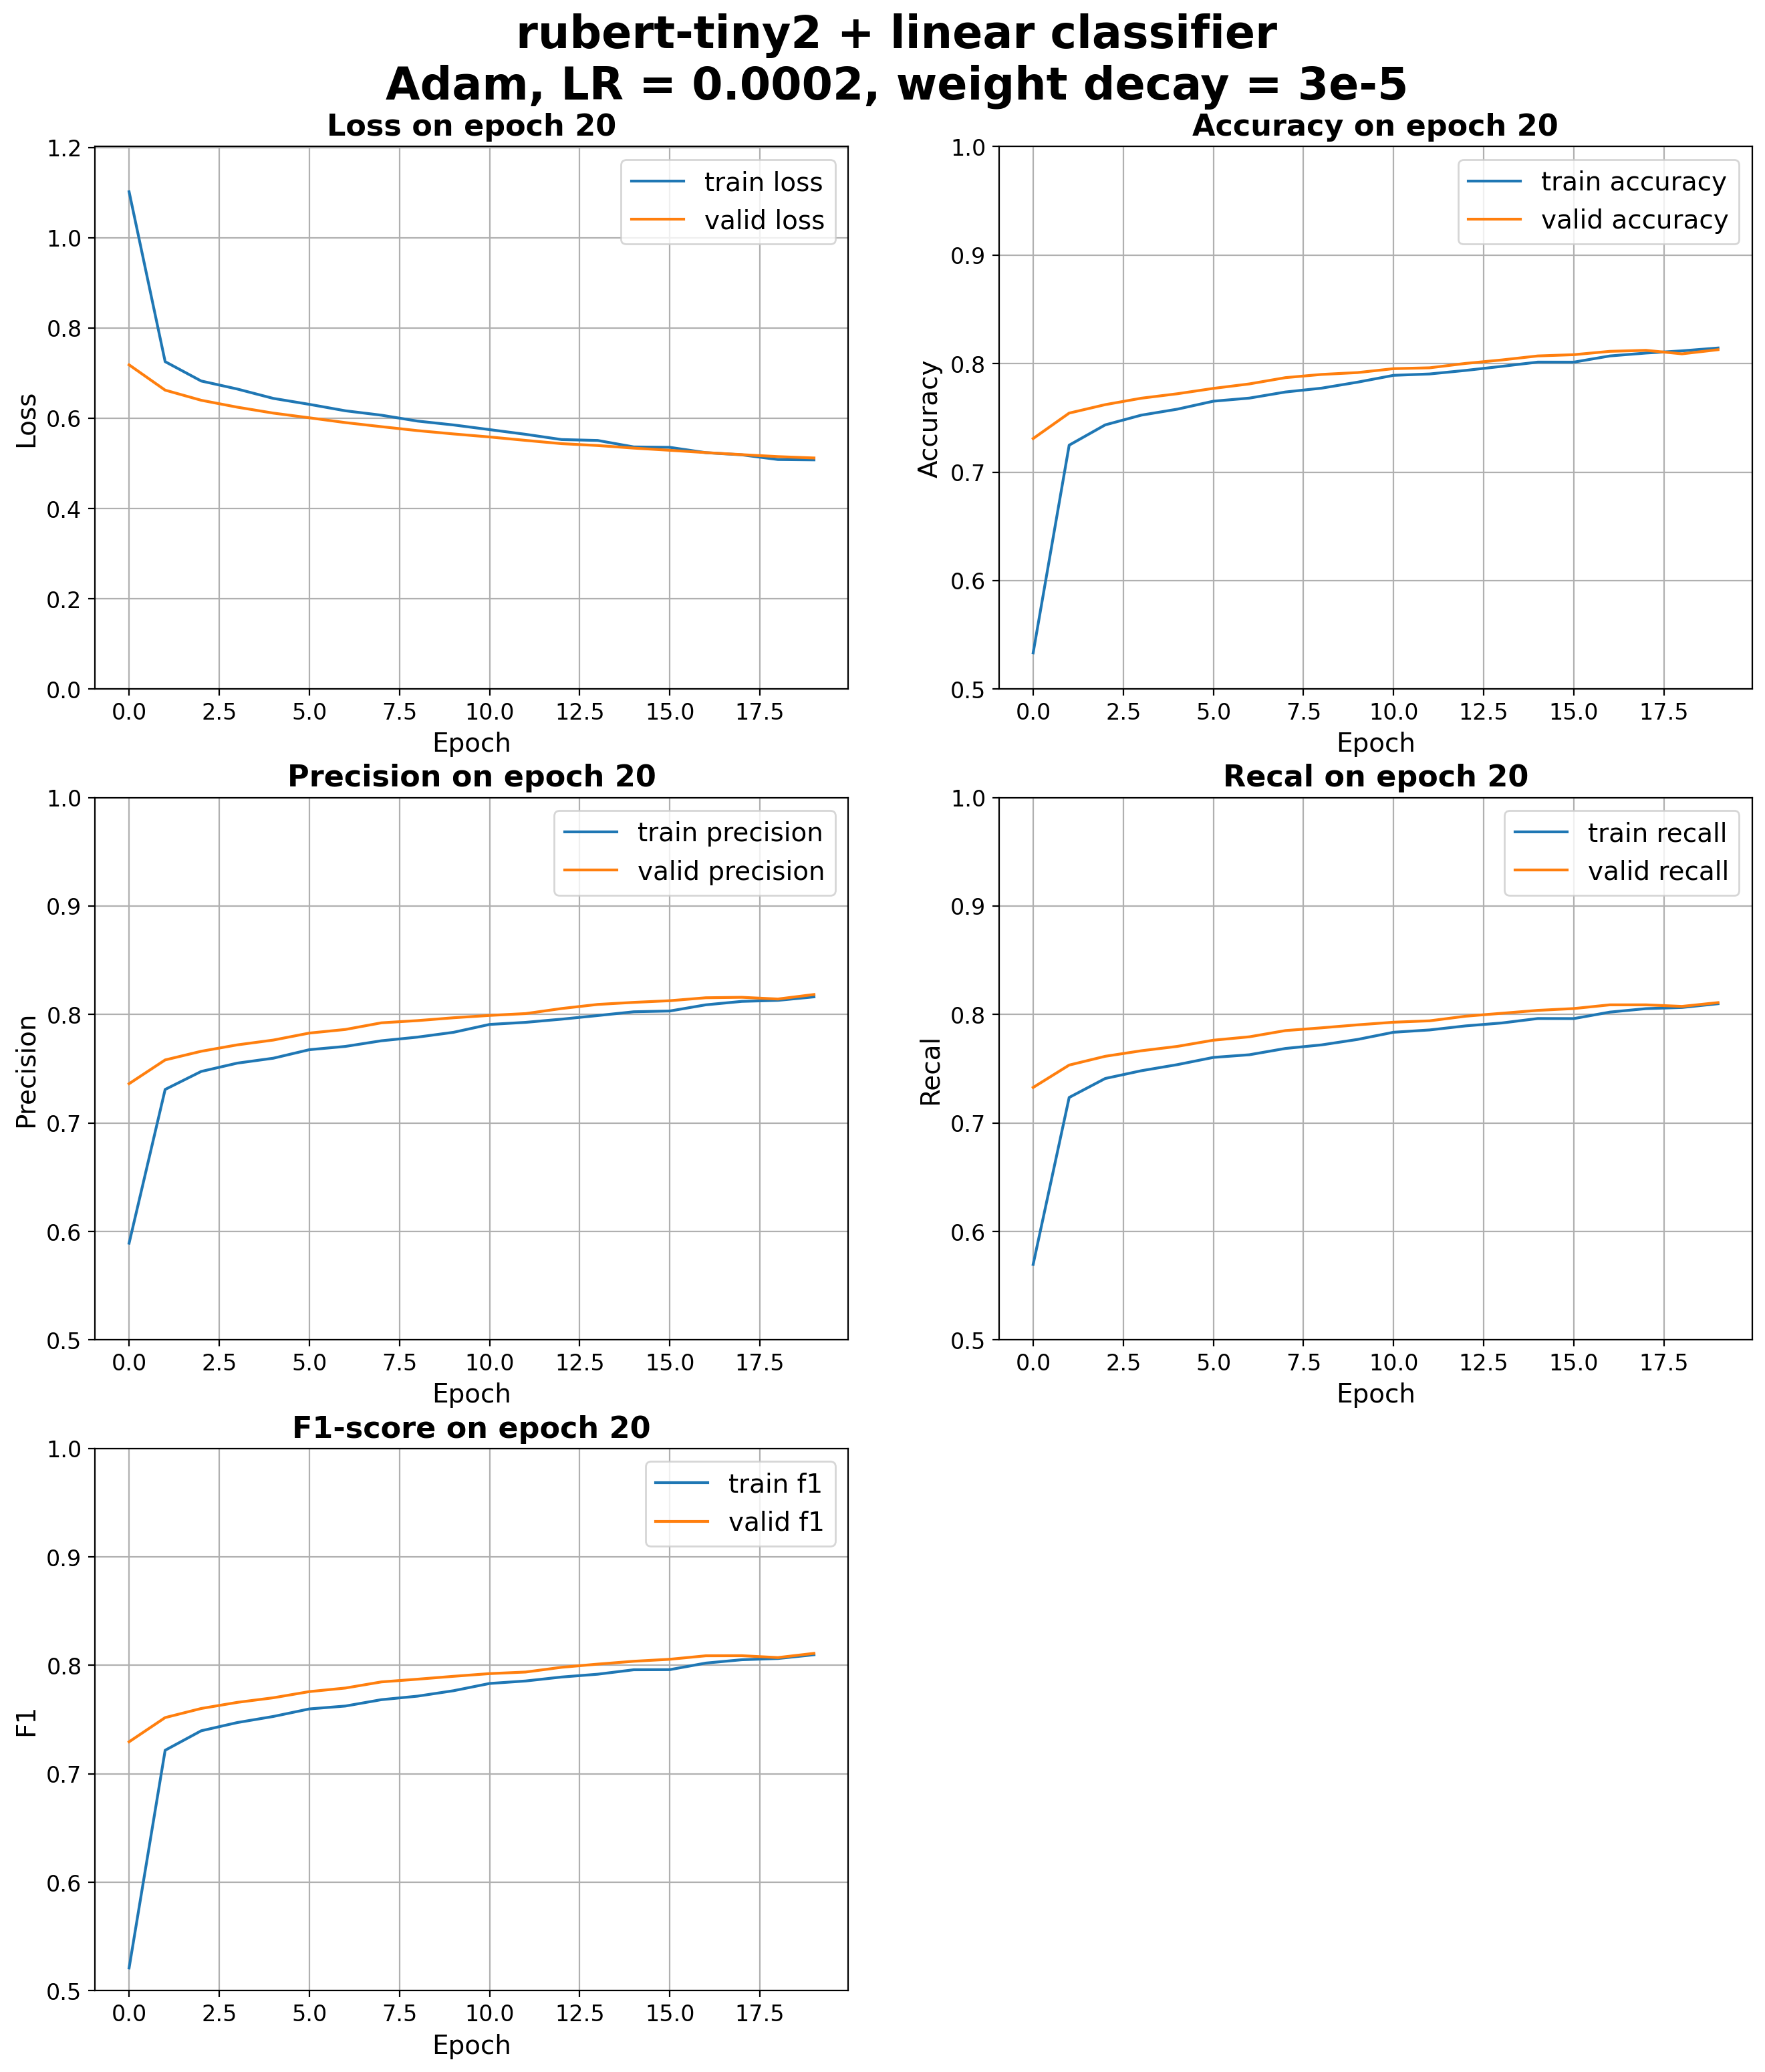

In [120]:
fig_2 = plot_history(
    logs,
    suptitle=f"rubert-tiny2 + linear classifier\nAdam, LR = {LR}, weight decay = 3e-5",
)

In [ ]:
# fig_2.savefig(
#     os.path.join(CURR_DIR, "results", "RuBert_learning.png"),
#     bbox_inches="tight",
#     dpi=300,
# )

#### Построим confusion matrix

* Используем тестовый датасет

In [124]:
df_test_encoded = encoder.fit_transform(df_test)
df_test_encoded["label"] = df_test_encoded["label"].astype(int)
df_test_encoded.head()

,label,date,content,initial_text
0,2,2023-05-24 06:42:11+00:00,Мастерство заголовков от РБК Прочитал заголово...,Мастерство заголовков от РБК Прочитал заголово...
1,4,2023-09-18 12:30:05+00:00,​Революция в оптимизаторах: DeepMind используе...,​Революция в оптимизаторах: DeepMind используе...
2,3,2022-10-10 06:25:33+00:00,Телеведущий Эта профессия считается довольно...,Телеведущий Эта профессия считается довольно...
3,0,2021-10-01 10:37:00+00:00,"​Когда-нибудь задумывались, что из-за поврежде...","​Когда-нибудь задумывались, что из-за поврежде..."
4,0,2023-02-12 13:04:31+00:00,Эта собака провела в отделении интенсивной тер...,Эта собака провела в отделении интенсивной тер...


In [142]:
df_test_encoded.shape

(5472, 4)

In [ ]:
encoded_test_input = (
    df_test_encoded["content"]
    .apply(
        lambda x: tokenizer_2(x, max_length=64, truncation=True, padding="max_length")
    )
    .values
)

In [147]:
encoded_test_input.shape

(5472,)

In [148]:
df_test_encoded["label"]

0       2
1       4
2       3
3       0
4       0
       ..
5467    0
5468    4
5469    4
5470    4
5471    2
Name: label, Length: 5472, dtype: int64

In [149]:
test_ds = TinyBertCLSInputs(
    encoded_text=encoded_test_input, y_true=df_test_encoded["label"]
)

In [151]:
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=128, shuffle=False, drop_last=False
)
batch = next(iter(test_loader))
batch

[tensor([[    2, 74858,  8868,  ..., 70291, 73361,     3],
         [    2, 43513,  2356,  ..., 42015, 23110,     3],
         [    2, 58233, 19523,  ...,     0,     0,     0],
         ...,
         [    2, 46034,   872,  ..., 52880,  7232,     3],
         [    2, 82239,   761,  ...,    18,  9006,     3],
         [    2, 71911,  1556,  ..., 58905,   314,     3]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([2, 4, 3, 0, 0, 2, 2, 4, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 0, 0, 3, 4, 1,
         4, 2, 4, 4, 3, 0, 2, 4, 3, 4, 0, 4, 4, 1, 3, 1, 3, 2, 2, 0, 2, 1, 1, 2,
         2, 0, 3, 3, 4, 4, 0, 0, 4, 4, 2, 0, 4, 4, 4, 4, 4, 2, 3, 2, 4, 4, 1, 1,
         4, 4, 1, 3, 0, 2, 2, 3, 4, 0, 1, 4, 4, 3, 4, 3, 2, 2, 4, 2, 4, 4, 3, 2,
         0, 0, 4, 0, 0, 4, 4, 4, 4, 0, 2, 3, 0, 0, 1, 3, 4, 2, 4, 4, 2, 3, 0, 4,

In [152]:
print(len(test_ds.inputs))
print(len(test_ds.labels))

5472
5472


#### Делаем предсказание

In [153]:
model_3.to("cpu")
model_3.eval()

y_pred_2 = []
y_true_2 = []

with torch.inference_mode():
    for inputs, masks, labels in test_loader:  # теперь берем labels
        inputs = inputs.to("cpu")
        masks = masks.to("cpu")
        labels = labels.to("cpu")

        outputs = model_3(inputs, masks)
        preds = torch.argmax(outputs, dim=1)  # классификация

        y_pred_2.extend(preds.cpu().numpy())
        y_true_2.extend(labels.cpu().numpy())

In [154]:
conf_matr = confusion_matrix(y_true=y_true_2, y_pred=y_pred_2)

Text(46.833333333333336, 0.5, 'True')

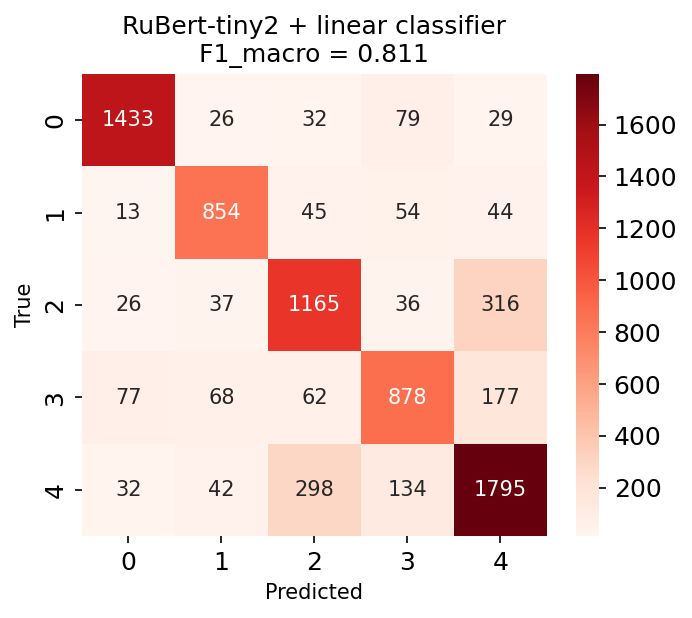

In [163]:
fig_3, ax_3 = plt.subplots(dpi=150, figsize=(5, 4))
sns.heatmap(conf_log, annot=True, fmt="d", cmap="Reds", ax=ax_3)
ax_3.set_title(
    f"RuBert-tiny2 + linear classifier\nF1_macro = {logs['valid_f1'][-1]:.3f}"
)
ax_3.set_xlabel("Predicted")
ax_3.set_ylabel("True")

In [ ]:
# fig_3.savefig(
#     os.path.join(CURR_DIR, "results", "RuBert_conf_matrix.png"),
#     bbox_inches="tight",
#     dpi=300,
# )